In [5]:
import os
import numpy as np
import xml.etree.ElementTree as etree
import skimage
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import random
import joblib
import pandas as pd
import seaborn as sns

In [22]:
# https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection/code


# Parsetja el fitxer xml i recupera la informació necessaria per trobar la cara de l'animal
#
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    :return annotation: diccionari
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    dds = []
    for obj in objects:
        dds.append(obj.find('name').text)
        dds.append([int(float(obj.find('bndbox/xmin').text)),
                    int(float(obj.find('bndbox/ymin').text)),
                    int(float(obj.find('bndbox/xmax').text)),
                    int(float(obj.find('bndbox/ymax').text))])

    return {'size': size, 'informacio': dds}


# Selecciona la cara de l'animal i la transforma a la mida indicat al paràmetre mida_desti
def retall_normalitzat(imatge, dades, mida_desti=(64, 64)):
    """
    Extreu la regió de la cara (ROI) i retorna una nova imatge de la mida_destí
    :param imatge: imatge que conté un animal
    :param dades: diccionari extret del xml
    :mida_desti: tupla que conté la mida que obtindrà la cara de l'animal
    """
    x, y, ample, alt = dades['informacio'][1]
    retall = np.copy(imatge[y:alt, x:ample])
    return resize(retall, mida_desti)


def obtenir_dades(carpeta_imatges, carpeta_anotacions, mida=(64, 64)):
    """Genera la col·lecció de cares d'animals i les corresponents etiquetes
    :param carpeta_imatges: string amb el path a la carpeta d'imatges
    :param carpeta_anotacions: string amb el path a la carpeta d'anotacions
    :param mida: tupla que conté la mida que obtindrà la cara de l'animal
    :return:
        images: numpy array 3D amb la col·lecció de cares
        etiquetes: llista binaria 0 si l'animal és un moix 1 en cas contrari
    """

    n_elements = len(
        [entry for entry in os.listdir(carpeta_imatges) if os.path.isfile(os.path.join(carpeta_imatges, entry))])
    # Una matriu 3D: mida x mida x nombre d'imatges
    imatges = np.zeros((mida[0], mida[1], n_elements), dtype=np.float16)
    # Una llista d'etiquetes
    etiquetes = [0] * n_elements

    #  Recorre els elements de les dues carpetes: llegeix una imatge i obté la informació interessant del xml
    with os.scandir(carpeta_imatges) as elements:
        for idx, element in enumerate(elements):
            nom = element.name.split(".")
            nom_fitxer = nom[0] + ".xml"
            imatge = imread(carpeta_imatges + os.sep + element.name, as_gray=True)
            anotacions = extract_xml_annotation(carpeta_anotacions + os.sep + nom_fitxer)

            cara_animal = retall_normalitzat(imatge, anotacions, mida)
            tipus_animal = anotacions["informacio"][0]

            imatges[:, :, idx] = cara_animal
            etiquetes[idx] = 0 if tipus_animal == "cat" else 1

    return imatges, etiquetes


def obtenirHoG(imatges):
    caracts = []
    aleatorias = random.sample(range(imatges.shape[2]), 5)
    seleccionadas = []  # Lista para almacenar los arrays con etiqueta, imagen original y HoG
    # Recorrido de los índices de las imágenes (eje z del array, con .shape[2])
    for i in range(imatges.shape[2]):
        out, hog_image = skimage.feature.hog(imatges[:, :, i],
                                             orientations=9,
                                             pixels_per_cell=(4, 4),
                                             cells_per_block=(2, 2),
                                             visualize=True)
        caracts.append(out)
        # Si el índice es uno de los aleatorios seleccionados, guarda la info
        if i in aleatorias:
            etiqueta = "Gato" if etiquetes[i] == 0 else "Perro"
            original = imatges[:, :, i]
            seleccionadas.append((etiqueta, original, hog_image))

    return caracts, seleccionadas

#OBTENER HOG DESDE IMAGENES

In [34]:
carpeta_images = "gatigos/images"  # NO ES POT MODIFICAR
carpeta_anotacions = "gatigos/annotations"  # NO ES POT MODIFICAR
mida = (128, 128)  # DEFINEIX LA MIDA, ES RECOMANA COMENÇAR AMB 64x64
imatges, etiquetes = obtenir_dades(carpeta_images, carpeta_anotacions, mida)
# Las imágenes ya fueron estandarizadas en obtenir_dades, ahora se convertirán a características HoG
caracteristiques, seleccionadas = obtenirHoG(imatges)
# Guardar las imágenes en .npy
np.save("imatges",imatges)
np.save("caracteristiques_"+str(mida[0]), caracteristiques)
np.save("etiquetas_"+str(mida[0]), etiquetes)

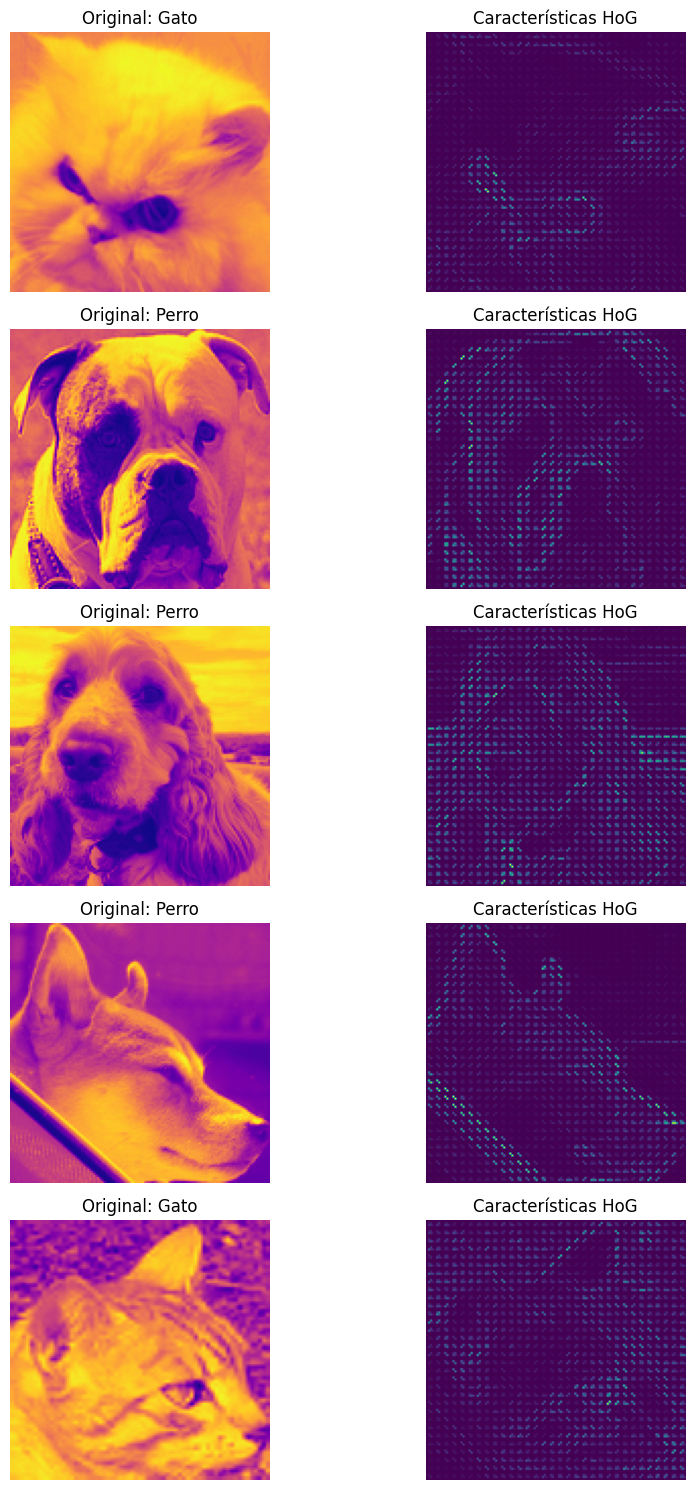

In [25]:
#Plotear las imágenes seleccionadas
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, (etiqueta, original, hog_image) in enumerate(seleccionadas):
    # Mostrar la imagen original en la primera columna
    axes[i, 0].imshow(original, cmap='plasma')
    axes[i, 0].set_title(f"Original: {etiqueta}")
    axes[i, 0].axis('off')

#Mostrar la imagen HoG en la segunda columna
    axes[i, 1].imshow(hog_image, cmap='viridis')
    axes[i, 1].set_title("Características HoG")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

#CARGAR HOG DESDE ARCHIVOS

In [35]:
imatges = np.load("imatges.npy")
caracteristiques = np.load("caracteristiques_128.npy")
etiquetes = np.load("etiquetas_128.npy")

#TRAIN Y TEST

In [38]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(caracteristiques, etiquetes, test_size=0.34, random_state=42)
_,Imagenes_test,_,_=train_test_split(imatges.transpose(2,0,1), etiquetes, test_size=0.34, random_state=42)

##Linear


###Gridsearch

In [4]:
param_grid = {'C' : [0.00001, 0.001, 10000, 100000], 'tol': [0.0000000001, 0.00001, 1]} # Grid para linear
# Crear y ajustar el modelo SVM con GridSearchCV
svm_linear = SVC(kernel='linear')
clf_linear = GridSearchCV(svm_linear, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
clf_linear.fit(X_train, y_train)
# Convertir los resultados a un DataFrame
resultados_linear = pd.DataFrame(clf_linear.cv_results_)

# Mostrar las columnas más importantes
columnas_interes = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(resultados_linear[columnas_interes])

# Mejor modelo encontrado
print("Mejores parámetros:", clf_linear.best_params_)

                         params  mean_test_score  std_test_score  \
0    {'C': 1e-05, 'tol': 1e-10}         0.682977        0.000184   
1    {'C': 1e-05, 'tol': 1e-05}         0.682977        0.000184   
2        {'C': 1e-05, 'tol': 1}         0.682977        0.000184   
3    {'C': 0.001, 'tol': 1e-10}         0.893504        0.006835   
4    {'C': 0.001, 'tol': 1e-05}         0.893504        0.006835   
5        {'C': 0.001, 'tol': 1}         0.900493        0.007152   
6    {'C': 10000, 'tol': 1e-10}         0.915707        0.003532   
7    {'C': 10000, 'tol': 1e-05}         0.915707        0.003532   
8        {'C': 10000, 'tol': 1}         0.913242        0.011210   
9   {'C': 100000, 'tol': 1e-10}         0.915707        0.003532   
10  {'C': 100000, 'tol': 1e-05}         0.915707        0.003532   
11      {'C': 100000, 'tol': 1}         0.913242        0.011210   

    rank_test_score  
0                10  
1                10  
2                10  
3                 8  
4    

###Test

####Comparativa top 1 Gridsearch

Se hace el test de los mejores modelos empatados para ver si alguno de ellos es realmente superior al resto.

In [5]:
# Evaluación de los modelos en el conjunto de prueba
# Filtrar los parámetros con el mejor rank_test_score (1)
mejores_modelos_params = resultados_linear[resultados_linear['rank_test_score'] == 1]['params'].tolist()

# Lista para almacenar resultados de cada modelo
modelos_y_metricas = []

# Entrenar un modelo para cada uno de los mejores parámetros
for params in mejores_modelos_params:
    # Crear el modelo con los parámetros específicos
    svm = SVC(kernel='linear', **params)
    svm.fit(X_train, y_train)

    # Evaluación en el conjunto de prueba
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Guardar las métricas del modelo
    modelos_y_metricas.append({
        'params': params,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    })

# Mostrar resultados de cada modelo
for i, modelo in enumerate(modelos_y_metricas):
    print("\n" + "-"*50 + "\n")
    print(f"Modelo {i + 1}:")
    print("Parámetros:", modelo['params'])
    print("Accuracy en conjunto de prueba:", modelo['accuracy'])
    print("Matriz de confusión:\n", modelo['confusion_matrix'])
    print("Reporte de clasificación:\n", modelo['classification_report'])
    print("\n" + "-"*50 + "\n")


--------------------------------------------------

Modelo 1:
Parámetros: {'C': 10000, 'tol': 1e-10}
Accuracy en conjunto de prueba: 0.9059011164274322
Matriz de confusión:
 [[357  60]
 [ 58 779]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       417
           1       0.93      0.93      0.93       837

    accuracy                           0.91      1254
   macro avg       0.89      0.89      0.89      1254
weighted avg       0.91      0.91      0.91      1254


--------------------------------------------------


--------------------------------------------------

Modelo 2:
Parámetros: {'C': 10000, 'tol': 1e-05}
Accuracy en conjunto de prueba: 0.9059011164274322
Matriz de confusión:
 [[357  60]
 [ 58 779]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       417
           1       0.93      0.93      0.93       837

    ac

Como se puede observar, los resultados de todos los modelos son exactamente iguales, entonces determinamos "el mejor" de forma arbitraria.

####Evaluación del best_estimator_

Accuracy en conjunto de prueba: 0.9059011164274322
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       417
           1       0.93      0.93      0.93       837

    accuracy                           0.91      1254
   macro avg       0.89      0.89      0.89      1254
weighted avg       0.91      0.91      0.91      1254



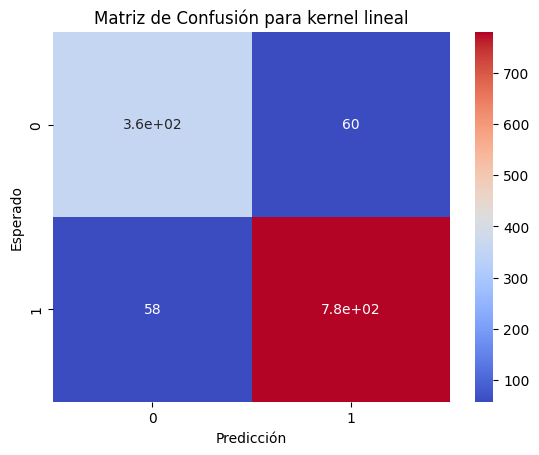

In [8]:
# Evaluación del modelo en el conjunto de prueba
y_pred_linear = clf_linear.best_estimator_.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
accurcy_gatos_linear = conf_matrix_linear[1][1]/(conf_matrix_linear[1][1]+conf_matrix_linear[1][0])
accuracy_perros_linear = conf_matrix_linear[0][0]/(conf_matrix_linear[0][0]+conf_matrix_linear[0][1])

# Imprimir resultados
print("Accuracy en conjunto de prueba:", accuracy_linear)
print(classification_report(y_test, y_pred_linear))

sns.heatmap(conf_matrix_linear, annot = True, cmap = 'coolwarm')
plt.xlabel('Predicción')
plt.ylabel('Esperado')
plt.title('Matriz de Confusión para kernel lineal');

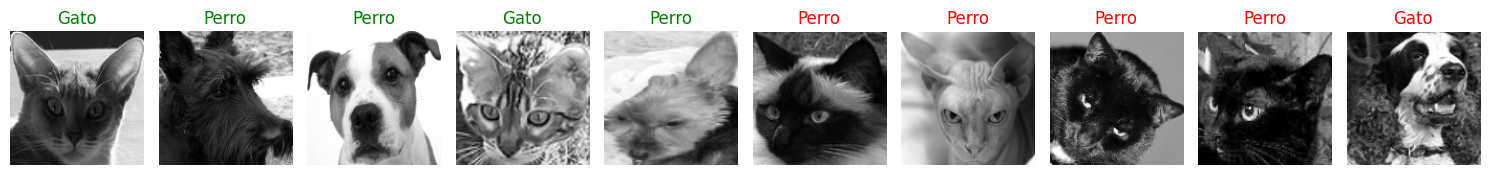

In [50]:
# Identificar índices de bien y mal clasificados
bien_clasificados = [i for i in range(len(y_test)) if y_test[i] == y_pred_linear[i]]
mal_clasificados = [i for i in range(len(y_test)) if y_test[i] != y_pred_linear[i]]

# Seleccionar 5 ejemplos aleatorios de cada tipo
ejemplos_bien = random.sample(bien_clasificados, min(5, len(bien_clasificados)))
ejemplos_mal = random.sample(mal_clasificados, min(5, len(mal_clasificados)))

# Concatenar ejemplos para mostrar
ejemplos = ejemplos_bien + ejemplos_mal
n_ejemplos = len(ejemplos)

# Crear figura para mostrar
fig, axes = plt.subplots(1, n_ejemplos, figsize=(15, 6))

for idx, ejemplo in enumerate(ejemplos):
    # Imágenes originales desde Imagenes_test
    axes[idx].imshow(Imagenes_test[ejemplo], cmap='gray')
    # Etiqueta según si fue bien clasificado o mal clasificado
    if ejemplo in ejemplos_bien:
        axes[idx].set_title("Gato" if y_test[ejemplo] == 0 else "Perro", color="green")
    else:
        axes[idx].set_title("Gato" if y_pred_linear[ejemplo] == 0 else "Perro", color="red")
    axes[idx].axis('off')  # Desactivar ejes en cada subplot

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

##RBF

###Gridsearch

In [6]:
param_grid = {'C' : [0.00001, 100, 100000], 'gamma': [ 0.001, 0.1, 10], 'tol': [0.00001, 1]} # Grid para rbf
# Crear y ajustar el modelo SVM con GridSearchCV
svm_rbf = SVC(kernel='rbf')
clf_rbf = GridSearchCV(svm_rbf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
clf_rbf.fit(X_train, y_train)
# Convertir los resultados a un DataFrame
resultados_rbf = pd.DataFrame(clf_rbf.cv_results_)

# Mostrar las columnas más importantes
print(resultados_rbf[columnas_interes])

# Mejor modelo encontrado
print("Mejores parámetros:", clf_rbf.best_params_)

                                         params  mean_test_score  \
0    {'C': 1e-05, 'gamma': 0.001, 'tol': 1e-05}         0.682977   
1        {'C': 1e-05, 'gamma': 0.001, 'tol': 1}         0.682977   
2      {'C': 1e-05, 'gamma': 0.1, 'tol': 1e-05}         0.682977   
3          {'C': 1e-05, 'gamma': 0.1, 'tol': 1}         0.682977   
4       {'C': 1e-05, 'gamma': 10, 'tol': 1e-05}         0.682977   
5           {'C': 1e-05, 'gamma': 10, 'tol': 1}         0.682977   
6      {'C': 100, 'gamma': 0.001, 'tol': 1e-05}         0.918998   
7          {'C': 100, 'gamma': 0.001, 'tol': 1}         0.917353   
8        {'C': 100, 'gamma': 0.1, 'tol': 1e-05}         0.682977   
9            {'C': 100, 'gamma': 0.1, 'tol': 1}         0.684622   
10        {'C': 100, 'gamma': 10, 'tol': 1e-05}         0.682977   
11            {'C': 100, 'gamma': 10, 'tol': 1}         0.682977   
12  {'C': 100000, 'gamma': 0.001, 'tol': 1e-05}         0.918998   
13      {'C': 100000, 'gamma': 0.001, 'tol': 1} 

###Test

####Comparativa top 1 Gridsearch

Se hace el test de los mejores modelos empatados para ver si alguno de ellos es realmente superior al resto.

In [9]:
# Evaluación de los modelos en el conjunto de prueba
# Filtrar los parámetros con el mejor rank_test_score (1)
mejores_modelos_params = resultados_rbf[resultados_rbf['rank_test_score'] == 1]['params'].tolist()

# Lista para almacenar resultados de cada modelo
modelos_y_metricas = []

# Entrenar un modelo para cada uno de los mejores parámetros
for params in mejores_modelos_params:
    # Crear el modelo con los parámetros específicos
    svm = SVC(kernel='rbf', **params)
    svm.fit(X_train, y_train)

    # Evaluación en el conjunto de prueba
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Guardar las métricas del modelo
    modelos_y_metricas.append({
        'params': params,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    })

# Mostrar resultados de cada modelo
for i, modelo in enumerate(modelos_y_metricas):
    print("\n" + "-"*50 + "\n")
    print(f"Modelo {i + 1}:")
    print("Parámetros:", modelo['params'])
    print("Accuracy en conjunto de prueba:", modelo['accuracy'])
    print("Matriz de confusión:\n", modelo['confusion_matrix'])
    print("Reporte de clasificación:\n", modelo['classification_report'])
    print("\n" + "-"*50 + "\n")


--------------------------------------------------

Modelo 1:
Parámetros: {'C': 100, 'gamma': 0.001, 'tol': 1e-05}
Accuracy en conjunto de prueba: 0.9170653907496013
Matriz de confusión:
 [[365  52]
 [ 52 785]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       417
           1       0.94      0.94      0.94       837

    accuracy                           0.92      1254
   macro avg       0.91      0.91      0.91      1254
weighted avg       0.92      0.92      0.92      1254


--------------------------------------------------


--------------------------------------------------

Modelo 2:
Parámetros: {'C': 100000, 'gamma': 0.001, 'tol': 1e-05}
Accuracy en conjunto de prueba: 0.9170653907496013
Matriz de confusión:
 [[365  52]
 [ 52 785]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       417
           1       0.94      0

Como se puede observar, nuevamente los resultados de todos los modelos son exactamente iguales, entonces determinamos "el mejor" de forma arbitraria.

####Evaluación del best_estimator_

Accuracy en conjunto de prueba: 0.9170653907496013
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       417
           1       0.94      0.94      0.94       837

    accuracy                           0.92      1254
   macro avg       0.91      0.91      0.91      1254
weighted avg       0.92      0.92      0.92      1254



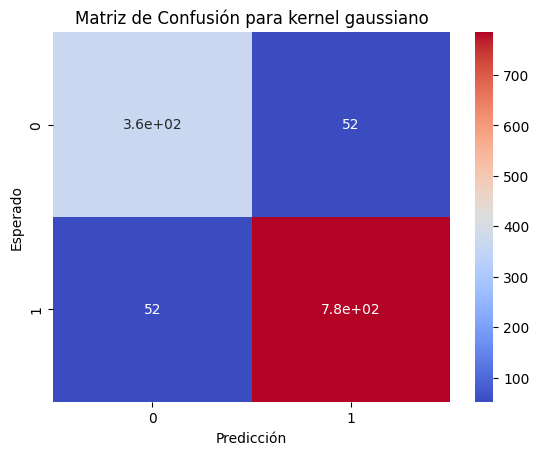

In [10]:
# Evaluación del modelo en el conjunto de prueba
y_pred_rbf = clf_rbf.best_estimator_.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
accurcy_gatos_rbf = conf_matrix_rbf[1][1]/(conf_matrix_rbf[1][1]+conf_matrix_rbf[1][0])
accuracy_perros_rbf = conf_matrix_rbf[0][0]/(conf_matrix_rbf[0][0]+conf_matrix_rbf[0][1])

# Imprimir resultados
print("Accuracy en conjunto de prueba:", accuracy_rbf)
print(classification_report(y_test, y_pred_rbf))

sns.heatmap(conf_matrix_rbf, annot = True, cmap = 'coolwarm')
plt.xlabel('Predicción')
plt.ylabel('Esperado')
plt.title('Matriz de Confusión para kernel gaussiano');

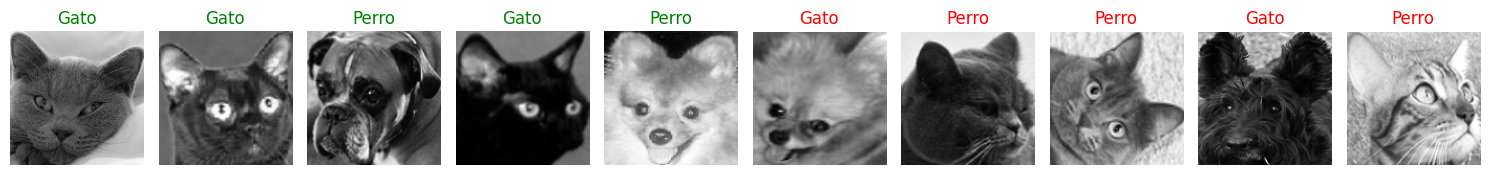

In [51]:
# Identificar índices de bien y mal clasificados
bien_clasificados = [i for i in range(len(y_test)) if y_test[i] == y_pred_rbf[i]]
mal_clasificados = [i for i in range(len(y_test)) if y_test[i] != y_pred_rbf[i]]

# Seleccionar 5 ejemplos aleatorios de cada tipo
ejemplos_bien = random.sample(bien_clasificados, min(5, len(bien_clasificados)))
ejemplos_mal = random.sample(mal_clasificados, min(5, len(mal_clasificados)))

# Concatenar ejemplos para mostrar
ejemplos = ejemplos_bien + ejemplos_mal
n_ejemplos = len(ejemplos)

# Crear figura para mostrar
fig, axes = plt.subplots(1, n_ejemplos, figsize=(15, 6))

for idx, ejemplo in enumerate(ejemplos):
    # Imágenes originales desde Imagenes_test
    axes[idx].imshow(Imagenes_test[ejemplo], cmap='gray')
    # Etiqueta según si fue bien clasificado o mal clasificado
    if ejemplo in ejemplos_bien:
        axes[idx].set_title("Gato" if y_test[ejemplo] == 0 else "Perro", color="green")
    else:
        axes[idx].set_title("Gato" if y_pred_rbf[ejemplo] == 0 else "Perro", color="red")
    axes[idx].axis('off')  # Desactivar ejes en cada subplot

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

##Poly


In [7]:
param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma': [ 0.001, 0.01, 0.1, 1, 10], 'degree': [2, 3, 4]} # Grid para poly
# Crear y ajustar el modelo SVM con GridSearchCV
svm_poly = SVC(kernel='poly')
clf_poly = GridSearchCV(svm_poly, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
clf_poly.fit(X_train, y_train)
# Convertir los resultados a un DataFrame
resultados_poly = pd.DataFrame(clf_poly.cv_results_)

# Mostrar las columnas más importantes
columnas_interes = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(resultados_poly[columnas_interes])

# Mejor modelo encontrado
print("Mejores parámetros:", clf_poly.best_params_)

                                      params  mean_test_score  std_test_score  \
0    {'C': 0.1, 'degree': 2, 'gamma': 0.001}         0.682977        0.000184   
1     {'C': 0.1, 'degree': 2, 'gamma': 0.01}         0.908716        0.008253   
2      {'C': 0.1, 'degree': 2, 'gamma': 0.1}         0.927223        0.006261   
3        {'C': 0.1, 'degree': 2, 'gamma': 1}         0.927223        0.006261   
4       {'C': 0.1, 'degree': 2, 'gamma': 10}         0.927223        0.006261   
..                                       ...              ...             ...   
70  {'C': 1000, 'degree': 4, 'gamma': 0.001}         0.932568        0.006450   
71   {'C': 1000, 'degree': 4, 'gamma': 0.01}         0.933802        0.007264   
72    {'C': 1000, 'degree': 4, 'gamma': 0.1}         0.933802        0.007264   
73      {'C': 1000, 'degree': 4, 'gamma': 1}         0.933802        0.007264   
74     {'C': 1000, 'degree': 4, 'gamma': 10}         0.934213        0.007539   

    rank_test_score  
0    

###Test

####Comparativa top 1 Gridsearch

Se hace el test de los mejores modelos empatados para ver si alguno de ellos es realmente superior al resto.

In [11]:
# Evaluación de los modelos en el conjunto de prueba
# Filtrar los parámetros con el mejor rank_test_score (1)
mejores_modelos_params = resultados_poly[resultados_poly['rank_test_score'] == 1]['params'].tolist()

# Lista para almacenar resultados de cada modelo
modelos_y_metricas = []

# Entrenar un modelo para cada uno de los mejores parámetros
for params in mejores_modelos_params:
    # Crear el modelo con los parámetros específicos
    svm = SVC(kernel='poly', **params)
    svm.fit(X_train, y_train)

    # Evaluación en el conjunto de prueba
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Guardar las métricas del modelo
    modelos_y_metricas.append({
        'params': params,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    })

# Mostrar resultados de cada modelo
for i, modelo in enumerate(modelos_y_metricas):
    print("\n" + "-"*50 + "\n")
    print(f"Modelo {i + 1}:")
    print("Parámetros:", modelo['params'])
    print("Accuracy en conjunto de prueba:", modelo['accuracy'])
    print("Matriz de confusión:\n", modelo['confusion_matrix'])
    print("Reporte de clasificación:\n", modelo['classification_report'])
    print("\n" + "-"*50 + "\n")


--------------------------------------------------

Modelo 1:
Parámetros: {'C': 0.1, 'degree': 4, 'gamma': 10}
Accuracy en conjunto de prueba: 0.9354066985645934
Matriz de confusión:
 [[371  46]
 [ 35 802]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       417
           1       0.95      0.96      0.95       837

    accuracy                           0.94      1254
   macro avg       0.93      0.92      0.93      1254
weighted avg       0.94      0.94      0.94      1254


--------------------------------------------------


--------------------------------------------------

Modelo 2:
Parámetros: {'C': 1, 'degree': 4, 'gamma': 10}
Accuracy en conjunto de prueba: 0.9354066985645934
Matriz de confusión:
 [[371  46]
 [ 35 802]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       417
           1       0.95      0.96      0.95

Como se puede observar, nuevamente los resultados de todos los modelos son exactamente iguales, entonces determinamos "el mejor" de forma arbitraria.

####Evaluación del best_estimator_

Accuracy en conjunto de prueba: 0.9354066985645934
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       417
           1       0.95      0.96      0.95       837

    accuracy                           0.94      1254
   macro avg       0.93      0.92      0.93      1254
weighted avg       0.94      0.94      0.94      1254



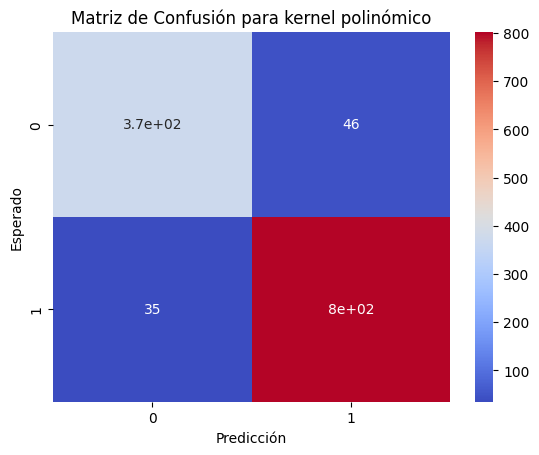

In [12]:
# Evaluación del modelo en el conjunto de prueba
y_pred_poly = clf_poly.best_estimator_.predict(X_test)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)
accurcy_gatos_poly = conf_matrix_poly[1][1]/(conf_matrix_poly[1][1]+conf_matrix_poly[1][0])
accuracy_perros_poly = conf_matrix_poly[0][0]/(conf_matrix_poly[0][0]+conf_matrix_poly[0][1])
# Imprimir resultados
print("Accuracy en conjunto de prueba:", accuracy_poly)
print(classification_report(y_test, y_pred_poly))

sns.heatmap(conf_matrix_poly, annot = True, cmap = 'coolwarm')
plt.xlabel('Predicción')
plt.ylabel('Esperado')
plt.title('Matriz de Confusión para kernel polinómico');

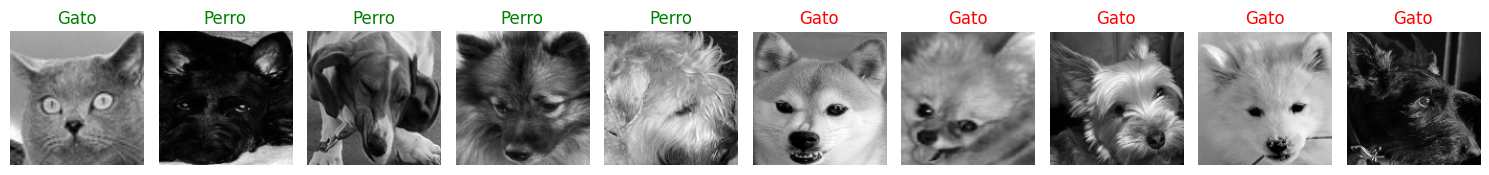

In [52]:
# Identificar índices de bien y mal clasificados
bien_clasificados = [i for i in range(len(y_test)) if y_test[i] == y_pred_poly[i]]
mal_clasificados = [i for i in range(len(y_test)) if y_test[i] != y_pred_poly[i]]

# Seleccionar 5 ejemplos aleatorios de cada tipo
ejemplos_bien = random.sample(bien_clasificados, min(5, len(bien_clasificados)))
ejemplos_mal = random.sample(mal_clasificados, min(5, len(mal_clasificados)))

# Concatenar ejemplos para mostrar
ejemplos = ejemplos_bien + ejemplos_mal
n_ejemplos = len(ejemplos)

# Crear figura para mostrar
fig, axes = plt.subplots(1, n_ejemplos, figsize=(15, 6))

for idx, ejemplo in enumerate(ejemplos):
    # Imágenes originales desde Imagenes_test
    axes[idx].imshow(Imagenes_test[ejemplo], cmap='gray')
    # Etiqueta según si fue bien clasificado o mal clasificado
    if ejemplo in ejemplos_bien:
        axes[idx].set_title("Gato" if y_test[ejemplo] == 0 else "Perro", color="green")
    else:
        axes[idx].set_title("Gato" if y_pred_poly[ejemplo] == 0 else "Perro", color="red")
    axes[idx].axis('off')  # Desactivar ejes en cada subplot

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

#Comparación entre modelos

Si bien todos los modelos presentan una precisión bastante similar, nos interesa saber cuál de estos presenta un mejor rendimiento. A continuación, presentaremos los resultados de cada uno de forma gráfica con tal de mostrar claramente las fortalezas y debilidades de cada uno de ellos.

##Comparativa de accuracy en general

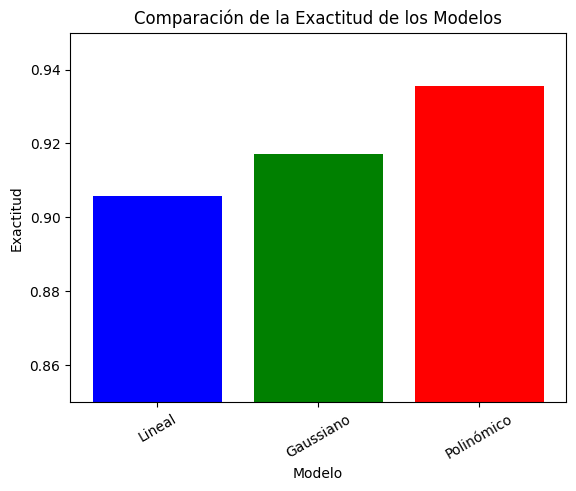

In [13]:
# Diccionario con título para cada modelo y su exactitud
model_accuracy = {
    'Lineal': accuracy_linear,
    'Gaussiano': accuracy_rbf,
    'Polinómico': accuracy_poly
}

# Barplot para comparar la exactitud en general
plt.bar(model_accuracy.keys(), model_accuracy.values(), color=['blue', 'green', 'red'])

# Ponemos nombre y formato a los ejes y a la gráfica
plt.xlabel('Modelo')
plt.ylabel('Exactitud')
plt.title('Comparación de la Exactitud de los Modelos')
plt.xticks(rotation=30)
# Establecer límites para el eje Y para amplificar las diferencias
plt.ylim(0.85, 0.95)

plt.show()

## Comparativa de precisión para identificar perros

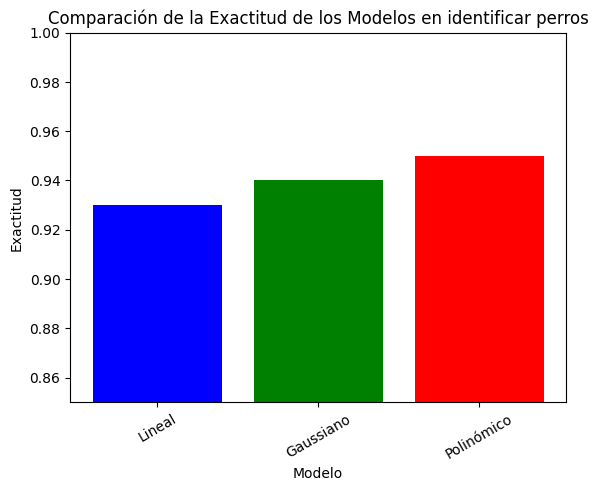

In [7]:
# Nos equivocamos con las variables y se llaman al revés
model_accuracy_gatos = {
  'Lineal': accuracy_gatos_linear,
  'Gaussiano': accuracy_gatos_rbf,
  'Polinómico': accuracy_gatos_poly
}


plt.bar(model_accuracy_gatos.keys(), model_accuracy_gatos.values(), color=['blue', 'green', 'red'])
# Ponemos nombre y formato a los ejes y a la gráfica
plt.xlabel('Modelo')
plt.ylabel('Exactitud')
plt.title('Comparación de la Exactitud de los Modelos en identificar perros')
plt.xticks(rotation=30)
# Establecer límites para el eje Y para amplificar las diferencias
plt.ylim(0.85, 1)

plt.show()

Como se puede observar, todos los modelos presentan resultados similares respecto a la identificación de perros, siendo los mejores el modelo gaussiano y el polinómico.

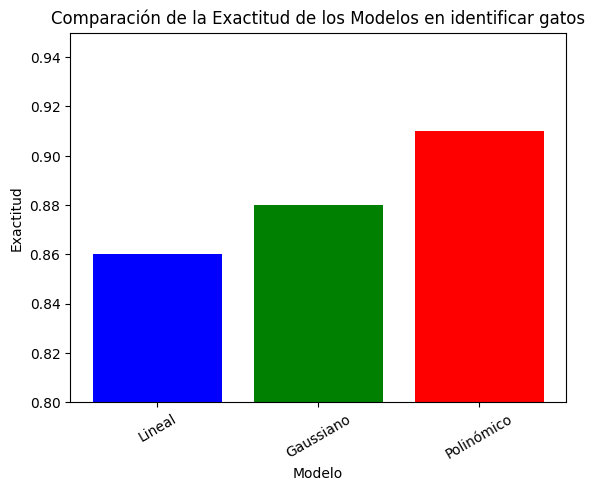

In [12]:
model_accuracy_perros = {
    'Lineal': accuracy_perros_linear,
    'Gaussiano': accuracy_perros_rbf,
    'Polinómico': accuracy_perros_poly
}
plt.bar(model_accuracy_perros.keys(), model_accuracy_perros.values(), color=['blue', 'green', 'red'])
# Ponemos nombre y formato a los ejes y a la gráfica
plt.xlabel('Modelo')
plt.ylabel('Exactitud')
plt.title('Comparación de la Exactitud de los Modelos en identificar gatos')
plt.xticks(rotation=30)
# Establecer límites para el eje Y para amplificar las diferencias
plt.ylim(0.8, 0.95)

plt.show()

Como se puede observar, todos los modelos presentan más dificultades a la hora de identificar gatos, esto se puede deber a que hay menos cantidad de imagenes para realizar test con gatos, esto podría estar generando que justamente las elegidas sean las peores, pero en la media saliese más alto de lo que vemos en realidad.